In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
import os
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pcbreviglieri/pneumonia-xray-images")

print("Path to dataset files:", path)

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 1.14G/1.14G [00:53<00:00, 23.0MB/s]

Extracting files...


Path to dataset files: /home/codespace/.cache/kagglehub/datasets/pcbreviglieri/pneumonia-xray-images/versions/1


In [5]:
os.listdir(path)

['train', 'val', 'test']

In [6]:
train_path = os.path.join(path, 'train')
train_path

'/home/codespace/.cache/kagglehub/datasets/pcbreviglieri/pneumonia-xray-images/versions/1/train'

In [7]:
classes = os.listdir(train_path)
classes

['opacity', 'normal']

In [8]:
normal_path = os.path.join(train_path, 'NORMAL')
pneumonia_path = os.path.join(train_path, 'PNEUMONIA')

In [9]:
normal_path

'/home/codespace/.cache/kagglehub/datasets/pcbreviglieri/pneumonia-xray-images/versions/1/train/NORMAL'

In [10]:
pneumonia_path

'/home/codespace/.cache/kagglehub/datasets/pcbreviglieri/pneumonia-xray-images/versions/1/train/PNEUMONIA'


Sample image files in 'normal' class:
['NORMAL2-IM-0388-0001.jpeg', 'IM-0655-0001.jpeg', 'IM-0491-0001.jpeg', 'IM-0191-0001.jpeg', 'IM-0340-0001.jpeg']

Sample image files in 'opacity' class:
['person2_bacteria_4.jpeg', 'person794_bacteria_2700.jpeg', 'person120_virus_226.jpeg', 'person445_virus_917.jpeg', 'person441_bacteria_1900.jpeg']


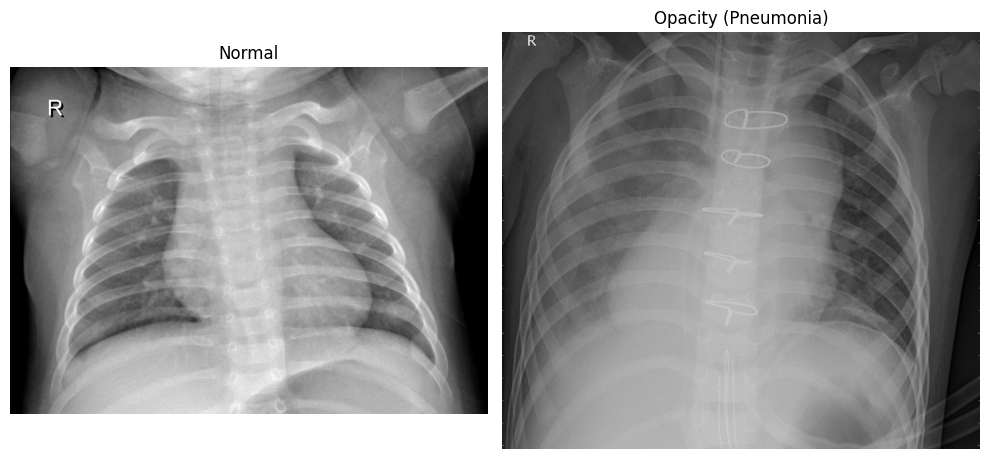

In [11]:
normal_path = os.path.join(train_path, 'normal')
opacity_path = os.path.join(train_path, 'opacity')

print("\nSample image files in 'normal' class:")
print(os.listdir(normal_path)[:5])

print("\nSample image files in 'opacity' class:")
print(os.listdir(opacity_path)[:5])

# Load and display a few sample images
plt.figure(figsize=(10, 5))

# Display a normal image
normal_img_path = os.path.join(normal_path, os.listdir(normal_path)[0])
normal_img = Image.open(normal_img_path)
plt.subplot(1, 2, 1)
plt.imshow(normal_img, cmap='gray')
plt.title('Normal')
plt.axis('off')

# Display an opacity image (representing pneumonia)
opacity_img_path = os.path.join(opacity_path, os.listdir(opacity_path)[0])
opacity_img = Image.open(opacity_img_path)
plt.subplot(1, 2, 2)
plt.imshow(opacity_img, cmap='gray')
plt.title('Opacity (Pneumonia)')
plt.axis('off')

plt.tight_layout()
plt.show()

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

import tensorflow as tf

2025-08-31 14:01:03.935808: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-31 14:01:04.937071: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-31 14:01:08.617741: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [14]:
train_dir = os.path.join(path, 'train')
val_dir = os.path.join(path, 'val')
test_dir = os.path.join(path, 'test')

img_size = (350, 350)
batch_size = 32

In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

In [16]:
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale'
)

Found 4192 images belonging to 2 classes.


In [18]:
validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale'
)

Found 1040 images belonging to 2 classes.


In [19]:
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False, # Keep data in order for evaluation
    color_mode='grayscale'
)

Found 624 images belonging to 2 classes.


In [20]:
print("Data generators created:")
print(f"Training generator: {train_generator}")
print(f"Validation generator: {validation_generator}")
print(f"Test generator: {test_generator}")

Data generators created:
Training generator: <keras.src.legacy.preprocessing.image.DirectoryIterator object at 0x7704c85f7cb0>
Validation generator: <keras.src.legacy.preprocessing.image.DirectoryIterator object at 0x7704c85f7b60>
Test generator: <keras.src.legacy.preprocessing.image.DirectoryIterator object at 0x7704c85f4500>


In [21]:
batchX, batchY = next(train_generator)
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Batch shape=(32, 350, 350, 1), min=0.000, max=1.000


In [22]:
labels = list(train_generator.class_indices.keys())
labels

['normal', 'opacity']

In [23]:
Counter(train_generator.classes)

Counter({np.int32(1): 3110, np.int32(0): 1082})

In [24]:
weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_generator.classes), y = train_generator.classes)
weights

array([1.93715342, 0.67395498])

In [25]:
cw = dict(zip(np.unique(train_generator.classes), weights))
cw

{np.int32(0): np.float64(1.9371534195933457),
 np.int32(1): np.float64(0.6739549839228296)}

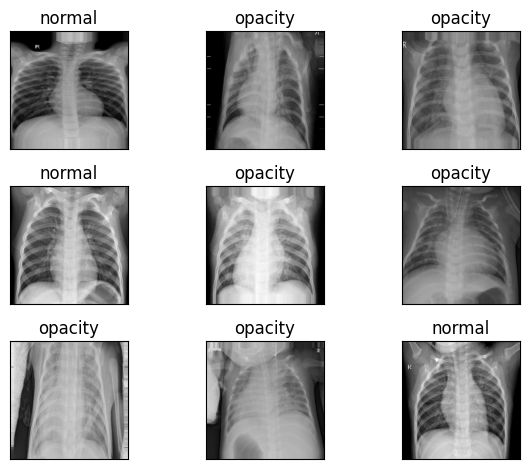

In [26]:
for i in range(9):
    ax = plt.subplot(3, 3, 1+i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('%s'%(labels[int(batchY[i])]))
    plt.imshow(batchX[i][:,:,0], cmap=plt.get_cmap('gray'))

plt.tight_layout()
plt.savefig('chest_xray.png', dpi=300)

In [27]:
input_shape = (350, 350, 1)

# Input
inputs = tf.keras.Input(shape=input_shape)

# Feature Extraction
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='last_conv_layer')(x)

# Image Classification
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

2025-08-31 14:01:55.928679: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [28]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 350, 350, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 348, 348, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 174, 174, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 172, 172, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 86, 86, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 84, 84, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 42, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 40, 40, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv_layer (Conv2D)        │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,700,897 (25.56 MB)

 Trainable params: 6,700,897 (25.56 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
ReduceLROnPlateau = tf.keras.callbacks.ReduceLROnPlateau

In [30]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.1, min_lr=0.000001)
callbacks_list = [learning_rate_reduction]

In [31]:
# Train the model
epochs = 10
history = model.fit(
    train_generator,
    callbacks=callbacks_list,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    class_weight=cw # Apply class weights to handle imbalance
)

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


2025-08-31 14:02:12.257636: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 496041984 exceeds 10% of free system memory.
2025-08-31 14:02:12.934913: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 124010496 exceeds 10% of free system memory.
2025-08-31 14:02:13.058902: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 121176064 exceeds 10% of free system memory.
2025-08-31 14:02:13.438720: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 57802752 exceeds 10% of free system memory.
2025-08-31 14:02:13.916778: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 57802752 exceeds 10% of free system memory.


131/131 ━━━━━━━━━━━━━━━━━━━━ 411s 3s/step - accuracy: 0.7979 - loss: 0.4244 - val_accuracy: 0.7783 - val_loss: 0.5077 - learning_rate: 0.0010
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 399s 3s/step - accuracy: 0.9010 - loss: 0.2441 - val_accuracy: 0.9189 - val_loss: 0.2072 - learning_rate: 0.0010
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 442s 3s/step - accuracy: 0.9077 - loss: 0.2443 - val_accuracy: 0.7930 - val_loss: 0.4102 - learning_rate: 0.0010
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 442s 3s/step - accuracy: 0.9072 - loss: 0.2182 - val_accuracy: 0.9551 - val_loss: 0.1609 - learning_rate: 0.0010
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 455s 3s/step - accuracy: 0.9210 - loss: 0.2004 - val_accuracy: 0.9531 - val_loss: 0.1232 - learning_rate: 0.0010
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 442s 3s/step - accuracy: 0.9344 - loss: 0.1529 - val_accuracy: 0.9512 - val_loss: 0.1505 - learning_rate: 0.0010
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9203 - loss: 0.1884
Epoch 7:

In [32]:
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 16s 817ms/step - accuracy: 0.9062 - loss: 0.3489
Test Loss: 0.3489
Test Accuracy: 0.9062


In [33]:
import plotly
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.express as px
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

import pandas as pd

In [34]:
h1 = go.Scatter(y=history.history['loss'],
                    mode="lines",
                    line=dict(
                        width=2,
                        color='blue'),
                        name="loss"
                   )
h2 = go.Scatter(y=history.history['val_loss'],
                    mode="lines",
                    line=dict(
                        width=2,
                        color='red'),
                        name="val_loss"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Loss',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig1 = go.Figure(data, layout=layout1)
plotly.offline.iplot(fig1)

In [35]:
h1 = go.Scatter(y=history.history['accuracy'],
                    mode="lines", line=dict(
                    width=2,
                    color='blue'),
                    name="acc"
                   )
h2 = go.Scatter(y=history.history['val_accuracy'],
                    mode="lines", line=dict(
                    width=2,
                    color='red'),
                    name="val_acc"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Accuracy',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig1 = go.Figure(data = data, layout=layout1)
plotly.offline.iplot(fig1)

In [36]:
predicted_classes = (model.predict(test_generator, verbose=1) > 0.5).astype("int32")[:,0]

20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 808ms/step


In [37]:
predicted_classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [38]:
test_generator.classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [39]:
def cm_plot(cm, labels):
    x = labels
    y = labels

    z_text = [[str(y) for y in x] for x in cm]
    fig = ff.create_annotated_heatmap(cm, x=x, y=y, annotation_text=z_text, colorscale='blues')

    fig.update_layout(title_text='Confusion Matrix')

    fig.add_annotation(dict(font=dict(color="black",size=13),
                            x=0.5,
                            y=-0.15,
                            showarrow=False,
                            text="Predicted Value",
                            xref="paper",
                            yref="paper"
                           ))

    fig.add_annotation(dict(font=dict(color="black",size=13),
                            x=-0.20,
                            y=0.5,
                            showarrow=False,
                            text="Real Value",
                            textangle=-90,
                            xref="paper",
                            yref="paper"
                           ))

    fig.update_layout(margin=dict(t=50, l=200))
    fig['layout']['yaxis']['autorange'] = "reversed"

    fig['data'][0]['showscale'] = True
    fig.show()

In [40]:
Counter(test_generator.classes)

Counter({np.int32(1): 390, np.int32(0): 234})

In [41]:
cm = confusion_matrix(test_generator.classes, predicted_classes)
cm

array([[185,  49],
       [  8, 382]])

In [42]:
cm_plot(cm, labels)

In [43]:
report = classification_report(test_generator.classes, predicted_classes, target_names=labels, digits=4)

print(report)

              precision    recall  f1-score   support

      normal     0.9585    0.7906    0.8665       234
     opacity     0.8863    0.9795    0.9306       390

    accuracy                         0.9087       624
   macro avg     0.9224    0.8850    0.8985       624
weighted avg     0.9134    0.9087    0.9065       624



In [44]:
y_score = model.predict(test_generator)
y_score = y_score[:,0]

20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 797ms/step


In [45]:
distribution_df = pd.DataFrame(data={'Score': y_score, 'Class': test_generator.classes})
distribution_df.sample(5)

,Score,Class
461,0.999000,1
495,0.999438,1
342,0.998038,1
586,0.816195,1
400,0.999794,1


In [46]:
distribution_df.loc[distribution_df['Class'] == 1, 'Class'] = 'opacity'
distribution_df.loc[distribution_df['Class'] == 0, 'Class'] = 'normal'
distribution_df.sample(5)

/tmp/ipykernel_3677/3628582695.py:1: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'opacity' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.



,Score,Class
41,0.009308,normal
250,0.999491,opacity
553,0.899210,opacity
443,0.999083,opacity
223,0.275556,normal


In [47]:
fig = px.histogram(distribution_df, x='Score', color='Class', nbins=50)
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.85)

In [48]:
fpr, tpr, threshold = roc_curve(test_generator.classes, y_score)
roc_auc = auc(fpr, tpr)

In [49]:
roc_df = pd.DataFrame(data={'False Positive Rate': fpr, 'True Positive Rate': tpr, 'Threshold': threshold})
roc_df.head()

,False Positive Rate,True Positive Rate,Threshold
0,0.0,0.000000,inf
1,0.0,0.002564,0.999985
2,0.0,0.020513,0.999918
3,0.0,0.025641,0.999917
4,0.0,0.182051,0.999609


In [50]:
def binary_roc_plot(roc_df, roc_auc):
    fig = px.area(
        data_frame=roc_df,
        x='False Positive Rate',
        y='True Positive Rate',
        hover_data=['Threshold'],
        title=f'ROC Curve (AUC={roc_auc:.4f})',
        width=700, height=500,
    )

    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1
    )

    hovertemplate = 'False Positive Rate=%{x:.4f}<br>True Positive Rate=%{y:.4f}<br>Threshold=%{customdata[0]:.4f}'
    fig.update_traces(hovertemplate=hovertemplate)

    fig.show()

In [51]:
binary_roc_plot(roc_df, roc_auc)

In [52]:
# Save the trained model
model.save('pneumonia_detection_model.keras')

In [53]:
# Load the saved model
loaded_model = tf.keras.models.load_model('pneumonia_detection_model.keras')

In [55]:
from transformers import pipeline
from PIL import Image
import requests
import torch

In [ ]:
import huggingface_hub

huggingface_hub.login()

In [ ]:
pipe = pipeline(
    "image-text-to-text",
    model="google/medgemma-4b-it",
    torch_dtype=torch.bfloat16,
    device="cuda",
)

In [ ]:
!pip install tf-keras-vis

In [ ]:
test_image_batch, label_batch = next(test_generator)

image = Image.fromarray((test_image_batch[0] * 255).astype('uint8').squeeze())

image

In [ ]:
label_batch[:32]

In [ ]:
image = Image.fromarray((test_image_batch[11] * 255).astype('uint8').squeeze())

image

In [ ]:
messages = [
    {
        "role": "system",
        "content": [{"type": "text", "text": "You are an expert radiologist."}]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "Describe this X-ray ดูว่าเป็น Pneumonia หรือไม่ (ตอบสั้นกระชับเป็นภาษาไทย)"},
            {"type": "image", "image": image}
        ]
    }
]

In [ ]:
output = pipe(text=messages, max_new_tokens=300)
print(output[0]["generated_text"][-1]["content"])

In [ ]:
image_array = np.array(image)
image_array.shape

In [ ]:
image_array = image_array.reshape(1, img_size[0], img_size[1], 1)

In [ ]:
image_array.shape

In [ ]:
image_array = image_array / 255.0

In [ ]:
cnn_prediction = model.predict(image_array)

predicted_class_index = (cnn_prediction > 0.5).astype("int32")[0][0]

In [ ]:
predicted_class_index

In [ ]:
labels

In [ ]:
predicted_class_label = labels[predicted_class_index]

print(f"CNN Model Prediction: {predicted_class_label}")
print(f"Prediction Probability: {cnn_prediction[0][0]:.4f}")

In [ ]:
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break

print(f"Last convolutional layer name: {last_conv_layer_name}")

In [ ]:
from tf_keras_vis.gradcam import Gradcam

In [ ]:
gradcam = Gradcam(model, model_modifier=None, clone=True)

In [ ]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

def custom_score(output):
    return output

heatmap = gradcam(custom_score,
                  image_array,
                  penultimate_layer=last_conv_layer_name)

heatmap = heatmap[0]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display original image
axes[0].imshow(image.convert('RGB'))
axes[0].set_title('Original Image')
axes[0].axis('off')

# Display GradCAM heatmap
axes[1].imshow(image.convert('RGB'))
axes[1].imshow(heatmap, cmap='jet', alpha=0.5) # Overlay the heatmap
axes[1].set_title('GradCAM Heatmap')
axes[1].axis('off')

plt.tight_layout()
plt.show()